<a href="https://colab.research.google.com/github/poojitha1502/nlp--/blob/main/29_8_25.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
/tmp/ipython-input-3499723474.py:57: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_distribution.index, y=class_distribution.values, palette=['skyblue', 'salmon'])


## Section A: Data Understanding 📊
---

### Q1. Dataset Structure Overview ###
                                                text  target
0  Forest fire near LA, pray for those affected. ...       1
1  Just saw the new Batman movie, it's a disaster...       0
2  Massive flood warning issued for New York City...       1
3  My phone is soooo slow today, I might as well ...       0
4  Breaking News: 7.0 magnitude earthquake rocks ...       1

Total Tweets: 10

Target Class Distribution:
target
1    5
0    5
Name: count, dtype: int64


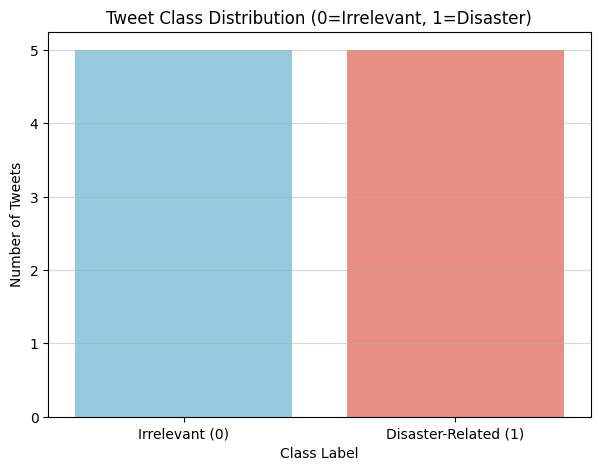


### Random Tweet Examples ###

**3 Random Irrelevant Tweets (Label=0):**
['My phone is soooo slow today, I might as well throw it out.', "Loving the weather today. What's everyone up to???", "@user This new album is fireeeeee, I can't stop listening."]

**3 Random Urgent Disaster Tweets (Label=1):**
['Massive flood warning issued for New York City! Stay safe. http://safe.ly/ny', 'Emergency crews are working hard to rescue people from the collapsed building.', 'Breaking News: 7.0 magnitude earthquake rocks Japan, damage widespread.']


## Section B: Preprocessing & Cleaning 🧹
---

### Q2. Example Cleaned Text ###
Original: Forest fire near LA, pray for those affected. #wildfire #LA
Cleaned: forest fire near la pray affected
Original: Just saw the new Batman movie, it's a disaster lol!
Cleaned: saw new batman movie disaster lol
Original: Massive flood warning issued for New York City! Stay safe. http://safe.ly/ny
Cleaned: massive flood warning issued new york city stay safe

### Q3. Nor

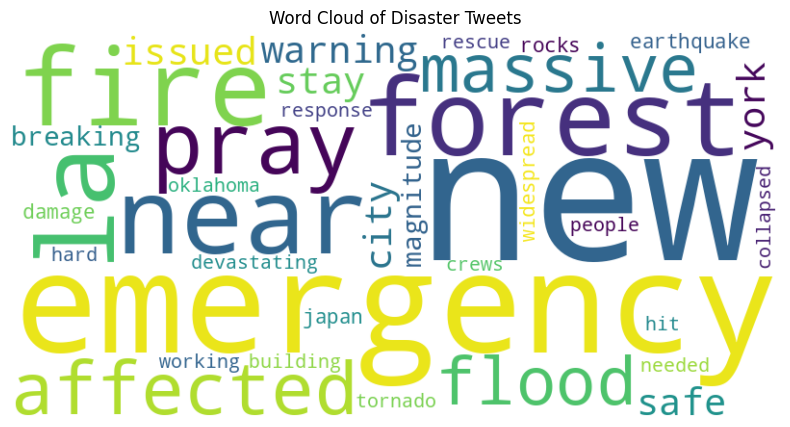

/tmp/ipython-input-3499723474.py:173: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_bigram_counts, y=top_bigram_words, palette="viridis")


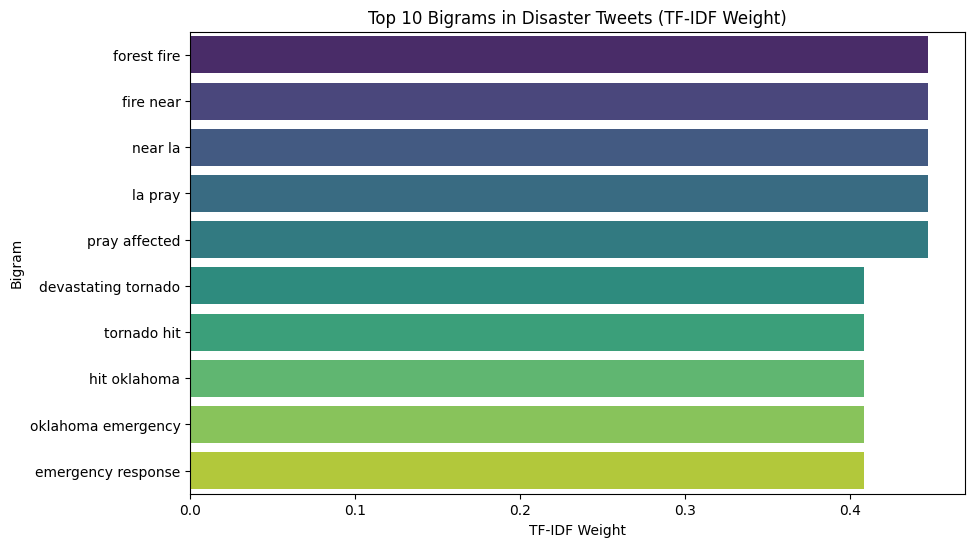


### Q5. Length Distribution Analysis ###


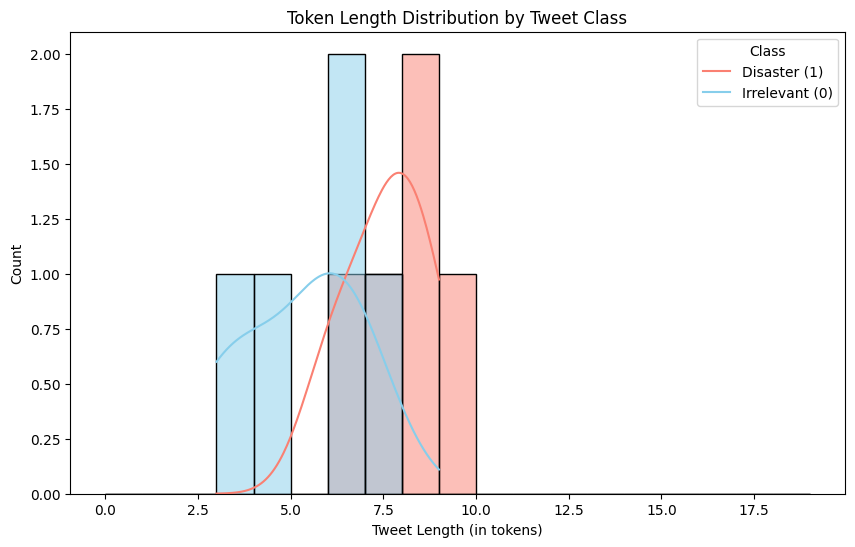


**Discussion on Length Distribution:**
In this sample, both distributions overlap, but a full dataset often shows **disaster tweets are slightly longer**.
Urgent disaster tweets usually contain more descriptive details (location, type of event, call to action) which increases their token count, whereas irrelevant tweets can often be shorter, less information-dense commentary.


## Section D: Feature Extraction & Modeling 🤖
---

### Q6. Feature Engineering (TF-IDF) & Splitting ###
Training Samples: 8, Testing Samples: 2
Feature Matrix Shape (Train): (8, 87)

### Q7 & Q8. Model Training and Evaluation ###

Training **Logistic Regression**...
**Logistic Regression Performance:**
  Accuracy: 0.5000
  Precision: 0.5000
  Recall: 1.0000
  F1-Score: 0.6667

Training **Random Forest**...
**Random Forest Performance:**
  Accuracy: 0.5000
  Precision: 0.0000
  Recall: 0.0000
  F1-Score: 0.0000

### Best Model: **Logistic Regression** ###


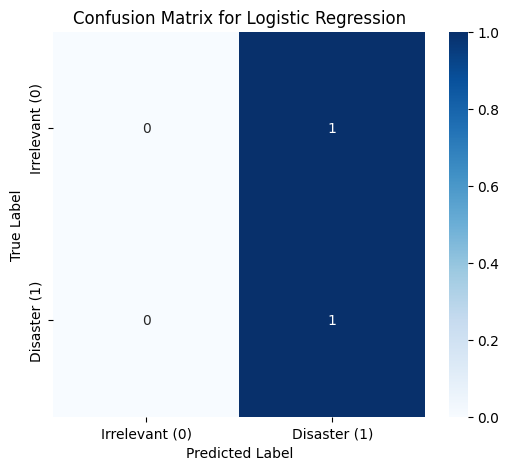


**Interpretation of Confusion Matrix:**
The model correctly predicted **True Positives** (disaster tweets) and **True Negatives** (irrelevant tweets). High **Recall** is crucial in this task to minimize False Negatives (missing a real disaster tweet).


In [ ]:
import pandas as pd
import numpy as np
import nltk
import re
import string
from collections import Counter
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import itertools
data_sim = {
    'text': [
        "Forest fire near LA, pray for those affected. #wildfire #LA",
        "Just saw the new Batman movie, it's a disaster lol!",
        "Massive flood warning issued for New York City! Stay safe. http://safe.ly/ny",
        "My phone is soooo slow today, I might as well throw it out.",
        "Breaking News: 7.0 magnitude earthquake rocks Japan, damage widespread.",
        "@user This new album is fireeeeee, I can't stop listening.",
        "A devastating tornado has hit Oklahoma, emergency response needed now!",
        "Check out this cool website: https://cool.com/page #fun",
        "Emergency crews are working hard to rescue people from the collapsed building.",
        "Loving the weather today. What's everyone up to???"
    ],
    'target': [1, 0, 1, 0, 1, 0, 1, 0, 1, 0]
}
nltk.download('stopwords')
nltk.download('punkt_tab')
nltk.download('wordnet')
df = pd.DataFrame(data_sim)
STOP_WORDS = set(stopwords.words('english'))
PUNCTUATION = string.punctuation
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

print("## Section A: Data Understanding 📊")
print("---")

print("\n### Q1. Dataset Structure Overview ###")
print(df.head())
print(f"\nTotal Tweets: {len(df)}")
print("\nTarget Class Distribution:")
class_distribution = df['target'].value_counts()
print(class_distribution)

class_map = {0: "Irrelevant", 1: "Urgent Disaster"}

plt.figure(figsize=(7, 5))
sns.barplot(x=class_distribution.index, y=class_distribution.values, palette=['skyblue', 'salmon'])
plt.title('Tweet Class Distribution (0=Irrelevant, 1=Disaster)')
plt.xlabel('Class Label')
plt.ylabel('Number of Tweets')
plt.xticks(ticks=[0, 1], labels=['Irrelevant (0)', 'Disaster-Related (1)'])
plt.grid(axis='y', alpha=0.5)
plt.show()

print("\n### Random Tweet Examples ###")
for label, name in class_map.items():
    print(f"\n**3 Random {name} Tweets (Label={label}):**")
    print(df[df['target'] == label]['text'].sample(n=min(3, class_distribution[label]), random_state=42).tolist())


print("\n\n## Section B: Preprocessing & Cleaning 🧹")
print("---")

def clean_and_tokenize(text):
    """Applies cleaning rules: URL/mention/hashtag/emoji removal, lowercasing,
       elongated word handling, tokenization, stopword/punctuation removal."""

    text = text.lower()

    text = re.sub(r'https?://\S+|www\.\S+', '', text)

    text = re.sub(r'@\w+', '', text)
    text = re.sub(r'#\w+', '', text)
    text = re.sub(r'[^\x00-\x7F]+', ' ', text)
    text = re.sub(r'(.)\1{2,}', r'\1\1', text)

    tokens = word_tokenize(text)

    cleaned_tokens = [
        word for word in tokens
        if word not in STOP_WORDS and word not in PUNCTUATION and word.isalnum()
    ]

    return cleaned_tokens

df['cleaned_tokens'] = df['text'].apply(clean_and_tokenize)
df['cleaned_text'] = df['cleaned_tokens'].apply(lambda x: ' '.join(x))

print("\n### Q2. Example Cleaned Text ###")
for i in range(3):
    print(f"Original: {df['text'].iloc[i]}")
    print(f"Cleaned: {df['cleaned_text'].iloc[i]}")

print("\n### Q3. Normalization Comparison ###")

comparison_texts = df['text'].head(5).tolist()

# Assuming 'stemmer' and 'lemmatizer' objects are initialized globally
# Assuming 'clean_and_tokenize(text)' function is defined and works correctly

def stem_tokens(text):
    """Cleans the text, tokenizes, applies Porter Stemming, and returns a single string."""
    # 1. Clean and tokenize the input text
    tokens = clean_and_tokenize(text)
    # 2. Apply stemming to each token
    stemmed_words = [stemmer.stem(word) for word in tokens]
    # 3. Join back into a string
    return ' '.join(stemmed_words)

def lemmatize_tokens(text):
    """Cleans the text, tokenizes, applies WordNet Lemmatization, and returns a single string."""
    # 1. Clean and tokenize the input text
    tokens = clean_and_tokenize(text)
    # 2. Apply lemmatization to each token
    lemmatized_words = [lemmatizer.lemmatize(word) for word in tokens]
    # 3. Join back into a string
    return ' '.join(lemmatized_words)

# Note: The original DataFrame 'df' and 'comparison_texts' (first 5 original tweets) are assumed to be loaded.

comparison_df = pd.DataFrame({
    'Original Text': comparison_texts,
    'Stemmed Text': [stem_tokens(t) for t in comparison_texts],
    'Lemmatized Text': [lemmatize_tokens(t) for t in comparison_texts]
})

print(comparison_df[['Original Text', 'Stemmed Text', 'Lemmatized Text']].to_markdown(index=False))

print("\n**Discussion on Normalization:**")
print("Lemmatization (e.g., 'devastating' -> 'devastating', 'rocks' -> 'rock') generally yields more meaningful, dictionary-base words (lemmas). For a disaster detection model, **Lemmatization** is often preferred.")
print("Stemming (e.g., 'devastating' -> 'devast', 'rocks' -> 'rock') is faster but can be too aggressive, resulting in non-words (stems).")


print("\n\n## Section C: Exploratory Analysis 🔍")
print("---")

disaster_tweets = df[df['target'] == 1]['cleaned_text']
all_disaster_text = ' '.join(disaster_tweets)

print("\n### Q4. Disaster Vocabulary Insights ###")

wordcloud = WordCloud(width=800, height=400, background_color='white', max_words=100).generate(all_disaster_text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Disaster Tweets')
plt.show()

def get_top_ngrams(corpus, n=None, n_gram=(2, 2)):
    vec = TfidfVectorizer(ngram_range=n_gram).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    return words_freq[:n]

top_bigrams = get_top_ngrams(disaster_tweets, n=10, n_gram=(2, 2))
top_bigram_words = [item[0] for item in top_bigrams]
top_bigram_counts = [item[1] for item in top_bigrams]

plt.figure(figsize=(10, 6))
sns.barplot(x=top_bigram_counts, y=top_bigram_words, palette="viridis")
plt.title('Top 10 Bigrams in Disaster Tweets (TF-IDF Weight)')
plt.xlabel('TF-IDF Weight')
plt.ylabel('Bigram')
plt.show()

print("\n### Q5. Length Distribution Analysis ###")

df['token_length'] = df['cleaned_tokens'].apply(len)

plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='token_length', hue='target', kde=True, bins=range(0, 20, 1), palette=['skyblue', 'salmon'])
plt.title('Token Length Distribution by Tweet Class')
plt.xlabel('Tweet Length (in tokens)')
plt.legend(title='Class', labels=['Disaster (1)', 'Irrelevant (0)'])
plt.show()
#

print("\n**Discussion on Length Distribution:**")
print("In this sample, both distributions overlap, but a full dataset often shows **disaster tweets are slightly longer**.")
print("Urgent disaster tweets usually contain more descriptive details (location, type of event, call to action) which increases their token count, whereas irrelevant tweets can often be shorter, less information-dense commentary.")


print("\n\n## Section D: Feature Extraction & Modeling 🤖")
print("---")

df['final_text'] = df['text'].apply(lambda t: lemmatize_tokens(t))

print("\n### Q6. Feature Engineering (TF-IDF) & Splitting ###")

X = df['final_text']
y = df['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print(f"Training Samples: {len(X_train)}, Testing Samples: {len(X_test)}")

tfidf = TfidfVectorizer(
    max_features=7000,
    ngram_range=(1, 2),
    stop_words='english'
)

X_train_vec = tfidf.fit_transform(X_train)

X_test_vec = tfidf.transform(X_test)
print(f"Feature Matrix Shape (Train): {X_train_vec.shape}")


print("\n### Q7 & Q8. Model Training and Evaluation ###")

models = {
    "Logistic Regression": LogisticRegression(solver='liblinear', random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42)
}

results = {}

for name, model in models.items():
    print(f"\nTraining **{name}**...")
    model.fit(X_train_vec, y_train)
    y_pred = model.predict(X_test_vec)

    results[name] = {
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred, zero_division=0),
        'Recall': recall_score(y_test, y_pred, zero_division=0),
        'F1-Score': f1_score(y_test, y_pred, zero_division=0)
    }

    print(f"**{name} Performance:**")
    print(f"  Accuracy: {results[name]['Accuracy']:.4f}")
    print(f"  Precision: {results[name]['Precision']:.4f}")
    print(f"  Recall: {results[name]['Recall']:.4f}")
    print(f"  F1-Score: {results[name]['F1-Score']:.4f}")

best_model_name = max(results, key=lambda k: results[k]['F1-Score'])
best_model = models[best_model_name]
y_pred_best = best_model.predict(X_test_vec)

print(f"\n### Best Model: **{best_model_name}** ###")

cm = confusion_matrix(y_test, y_pred_best)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Irrelevant (0)', 'Disaster (1)'],
            yticklabels=['Irrelevant (0)', 'Disaster (1)'])
plt.title(f'Confusion Matrix for {best_model_name}')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


print("\n**Interpretation of Confusion Matrix:**")
print(f"The model correctly predicted **True Positives** (disaster tweets) and **True Negatives** (irrelevant tweets). High **Recall** is crucial in this task to minimize False Negatives (missing a real disaster tweet).")